# LSTM for Rare Event Binary Classification


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [18]:
df = pd.read_csv("combined_filtered.csv") 
df.head(n=5) 

,Unnamed: 0,_time,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04,Anomally,Success
0,0,2023-09-19T14:21:53.393Z,1,0,0,1857,11866,1693,2390,2640,11855,0,1
1,1,2023-09-19T14:21:53.485Z,1,0,0,1862,11896,1679,2396,2643,11908,0,1
2,2,2023-09-19T14:21:53.582Z,1,0,0,1867,11957,1669,2379,2659,11939,0,1
3,3,2023-09-19T14:21:53.687Z,1,0,0,1886,11955,1699,2403,2612,11932,0,1
4,4,2023-09-19T14:21:53.793Z,1,0,0,1887,11966,1670,2388,2630,11931,0,1


In [19]:
df=df.drop(['Unnamed: 0'], axis=1)
df

,_time,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04,Anomally,Success
0,2023-09-19T14:21:53.393Z,1,0,0,1857,11866,1693,2390,2640,11855,0,1
1,2023-09-19T14:21:53.485Z,1,0,0,1862,11896,1679,2396,2643,11908,0,1
2,2023-09-19T14:21:53.582Z,1,0,0,1867,11957,1669,2379,2659,11939,0,1
3,2023-09-19T14:21:53.687Z,1,0,0,1886,11955,1699,2403,2612,11932,0,1
4,2023-09-19T14:21:53.793Z,1,0,0,1887,11966,1670,2388,2630,11931,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
216029,2023-09-19T20:21:59.584Z,0,0,0,1888,2061,1676,2382,2604,11801,1,0
216030,2023-09-19T20:21:59.686Z,0,0,0,1854,2061,1686,2404,2776,11878,1,0
216031,2023-09-19T20:21:59.785Z,0,0,0,1859,2073,1685,2403,3218,11917,1,0
216032,2023-09-19T20:21:59.887Z,0,0,0,1860,2067,1655,2385,2176,11904,1,0


In [20]:
df['Anomally'] = df['Anomally'].replace({'N': 0, 'Y': 1})
df
df=df.rename(columns={"Success?": "Success"})

df['Success'] = df['Success'].replace({'N': 0, 'Y': 1})
df

,_time,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04,Anomally,Success
0,2023-09-19T14:21:53.393Z,1,0,0,1857,11866,1693,2390,2640,11855,0,1
1,2023-09-19T14:21:53.485Z,1,0,0,1862,11896,1679,2396,2643,11908,0,1
2,2023-09-19T14:21:53.582Z,1,0,0,1867,11957,1669,2379,2659,11939,0,1
3,2023-09-19T14:21:53.687Z,1,0,0,1886,11955,1699,2403,2612,11932,0,1
4,2023-09-19T14:21:53.793Z,1,0,0,1887,11966,1670,2388,2630,11931,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
216029,2023-09-19T20:21:59.584Z,0,0,0,1888,2061,1676,2382,2604,11801,1,0
216030,2023-09-19T20:21:59.686Z,0,0,0,1854,2061,1686,2404,2776,11878,1,0
216031,2023-09-19T20:21:59.785Z,0,0,0,1859,2073,1685,2403,3218,11917,1,0
216032,2023-09-19T20:21:59.887Z,0,0,0,1860,2067,1655,2385,2176,11904,1,0


In [21]:
df=df.drop(['Anomally'], axis=1)

In [22]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    vector = df['Success'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'Success'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [23]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['Success'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -70)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,_time,GreenRocket,Door1,Door2,LoadCell_R02


After shifting


,Success,_time,GreenRocket,Door1,Door2


In [24]:
# Remove time column, and the categorical columns
df = df.drop(['_time'], axis=1)

In [25]:
df

,Success,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04
59019,0.0,0,1,0,1877,12035,1697,2388,2522,12053
59020,0.0,0,1,0,1914,12125,1697,2388,2651,12150
59021,0.0,0,1,0,1898,12073,1690,2392,2460,12003
59022,0.0,0,1,0,1887,12084,1710,2387,2493,12082
59023,0.0,0,1,0,1889,12054,1694,2380,2526,12108
...,...,...,...,...,...,...,...,...,...,...
216029,0.0,0,0,0,1888,2061,1676,2382,2604,11801
216030,0.0,0,0,0,1854,2061,1686,2404,2776,11878
216031,0.0,0,0,0,1859,2073,1685,2403,3218,11917
216032,0.0,0,0,0,1860,2067,1655,2385,2176,11904


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3738 entries, 59019 to 216033
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Success            3738 non-null   float64
 1   GreenRocket        3738 non-null   int64  
 2   Door1              3738 non-null   int64  
 3   Door2              3738 non-null   int64  
 4   LoadCell_R02       3738 non-null   int64  
 5   Potentiometer_R02  3738 non-null   int64  
 6   LoadCell_R03       3738 non-null   int64  
 7   Potentiometer_R03  3738 non-null   int64  
 8   LoadCell_R04       3738 non-null   int64  
 9   Potentiometer_R04  3738 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 321.2 KB


In [27]:
input_X = df.loc[:, df.columns != 'Success'].values  # converts the df to a numpy array
input_y = df['Success'].values

n_features = input_X.shape[1]  # number of features

In [28]:
n_features

9

In [29]:
input_y

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
input_X

array([[    0,     1,     0, ...,  2388,  2522, 12053],
       [    0,     1,     0, ...,  2388,  2651, 12150],
       [    0,     1,     0, ...,  2392,  2460, 12003],
       ...,
       [    0,     0,     0, ...,  2403,  3218, 11917],
       [    0,     0,     0, ...,  2385,  2176, 11904],
       [    0,     0,     0, ...,  2396,  3437, 11906]])

In [31]:
n_features

9

In [32]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [33]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 ))) 

First instance of y = 1 in the original data


,Success,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04
60699,0.0,1,0,0,1857,11885,1695,2400,2654,11838
60700,0.0,1,0,0,1868,11939,1695,2392,2661,11905
60701,0.0,1,0,0,1876,11899,1682,2403,2586,11790
60702,0.0,1,0,0,1861,11896,1682,2384,2680,11847
60703,0.0,1,0,0,1859,11974,1693,2403,2707,11931
60704,1.0,1,0,0,1870,11890,1691,2403,2924,12086


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8
0,1,0,0,1868,11939,1695,2392,2661,11905
1,1,0,0,1876,11899,1682,2403,2586,11790
2,1,0,0,1861,11896,1682,2384,2680,11847
3,1,0,0,1859,11974,1693,2403,2707,11931
4,1,0,0,1870,11890,1691,2403,2924,12086


In [34]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)


In [35]:
X_train.shape

(2388, 5, 1, 9)

In [36]:
np.array(y)

array([0., 0., 0., ..., 0., 0., 0.])

In [37]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [38]:
X_train_y0.shape

(2275, 5, 1, 9)

In [39]:
X_valid_y0.shape

(559, 5, 1, 9)

#### Reshaping the data
The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [40]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [41]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [42]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [43]:
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [44]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means 
and variances are 0 and 1, respectively, after
flattening.
'''
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0.36044  -0.428132  0.        0.013187 -0.376264 -0.003077  0.243956
 -0.021099  0.043516]
colwise variance [0.23052288 0.24483497 0.         0.45345248 0.36392011 0.45581471
 0.18444149 0.61581857 0.49876566]


In [45]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

# LSTM training

In [47]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

epochs = 100
batch = 64
lr = 0.001

In [48]:

lstm = Sequential()
lstm.add(LSTM(64, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm.add(LSTM(128, activation='relu', return_sequences=True))
lstm.add(LSTM(128, activation='relu', return_sequences=True))
lstm.add(LSTM(64, activation='relu', return_sequences=True))
lstm.add(LSTM(32, activation='relu', return_sequences=True))
lstm.add(TimeDistributed(Dense(n_features)))
lstm.compile(optimizer='adam', loss='mse')

lstm.summary()

2023-10-16 13:08:27.011413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             18944     
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            98816     
                                                                 
 lstm_2 (LSTM)               (None, 5, 128)            131584    
                                                                 
 lstm_3 (LSTM)               (None, 5, 64)             49408     
                                                                 
 lstm_4 (LSTM)               (None, 5, 32)             12416     
                                                                 
 time_distributed (TimeDistr  (None, 5, 9)             297       
 ibuted)                                                         
                                                        

In [49]:
adam = optimizers.Adam(lr)
lstm.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_classifier_mcnair_success.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_history = lstm.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Epoch 1/100
36/36 - 3s - loss: 0.3863 - val_loss: 0.3893 - 3s/epoch - 91ms/step
Epoch 2/100
36/36 - 1s - loss: 0.3439 - val_loss: 0.3465 - 542ms/epoch - 15ms/step
Epoch 3/100
36/36 - 1s - loss: 0.2927 - val_loss: 0.2896 - 540ms/epoch - 15ms/step
Epoch 4/100
36/36 - 1s - loss: 0.2513 - val_loss: 0.2465 - 540ms/epoch - 15ms/step
Epoch 5/100
36/36 - 1s - loss: 0.2140 - val_loss: 0.2040 - 538ms/epoch - 15ms/step
Epoch 6/100
36/36 - 1s - loss: 0.1827 - val_loss: 0.1690 - 537ms/epoch - 15ms/step
Epoch 7/100
36/36 - 1s - loss: 0.1604 - val_loss: 0.1543 - 536ms/epoch - 15ms/step
Epoch 8/100
36/36 - 1s - loss: 0.1432 - val_loss: 0.1335 - 538ms/epoch - 15ms/step
Epoch 9/100
36/36 - 1s - loss: 0.1216 - val_loss: 0.1165 - 537ms/epoch - 15ms/step
Epoch 10/100
36/36 - 1s - loss: 0.1041 - val_loss: 0.0989 - 547ms/epoch - 15ms/step
Epoch 11/100
36/36 - 1s - loss: 0.0877 - val_loss: 0.0874 - 529ms/epoch - 15ms/step
Epoch 12/100
36/36 - 1s - loss: 0.0764 - val_loss: 0.0765 - 535ms/epoch - 15ms/step
Epoc

36/36 - 1s - loss: 7.5400e-04 - val_loss: 0.0019 - 536ms/epoch - 15ms/step
Epoch 99/100
36/36 - 1s - loss: 0.0010 - val_loss: 0.0017 - 536ms/epoch - 15ms/step
Epoch 100/100
36/36 - 1s - loss: 8.3061e-04 - val_loss: 0.0017 - 536ms/epoch - 15ms/step


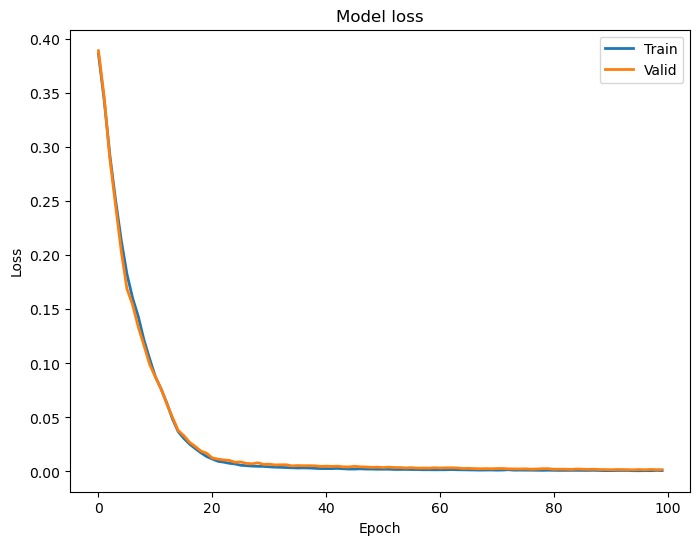

In [50]:
plt.plot(lstm_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

75/75 [==============================] - 1s 4ms/step


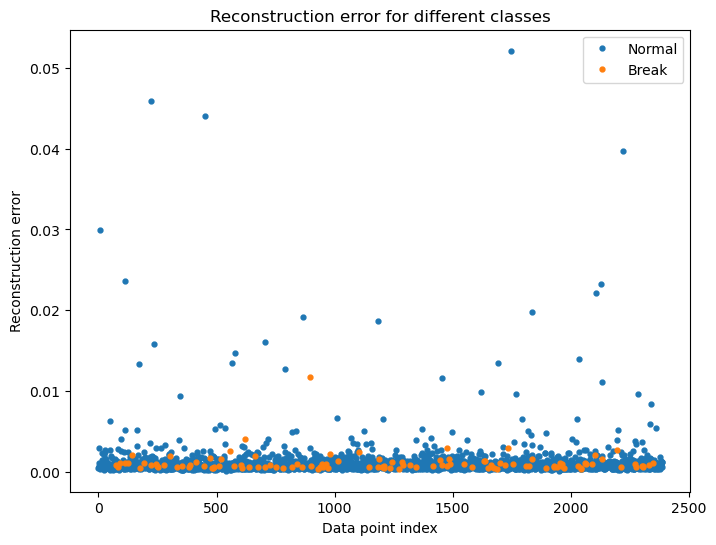

In [51]:
train_x_predictions = lstm.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Predictions using the lstm

19/19 [==============================] - 0s 4ms/step


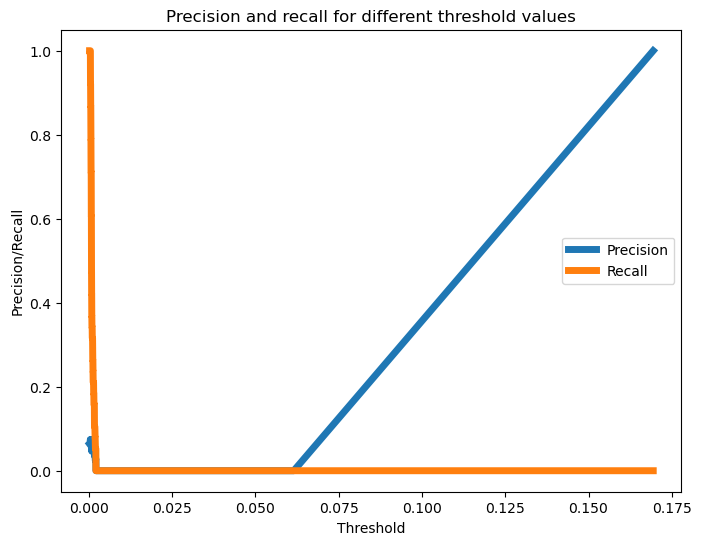

In [52]:
valid_x_predictions = lstm.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

24/24 [==============================] - 0s 4ms/step


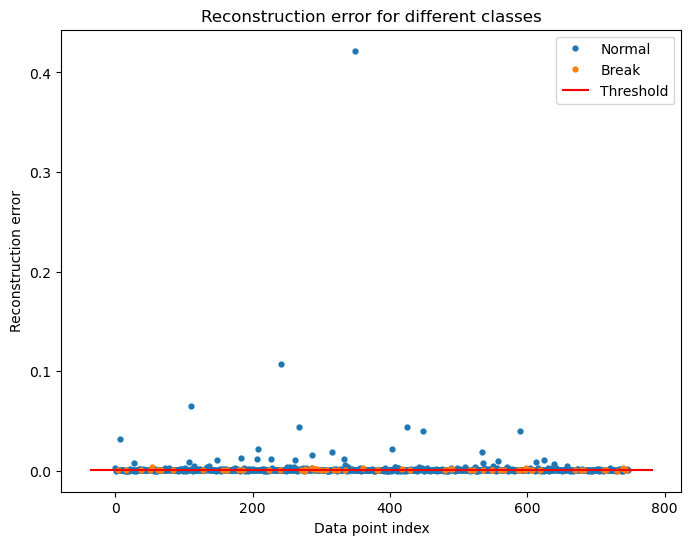

In [57]:
test_x_predictions = lstm.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.0005
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [58]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

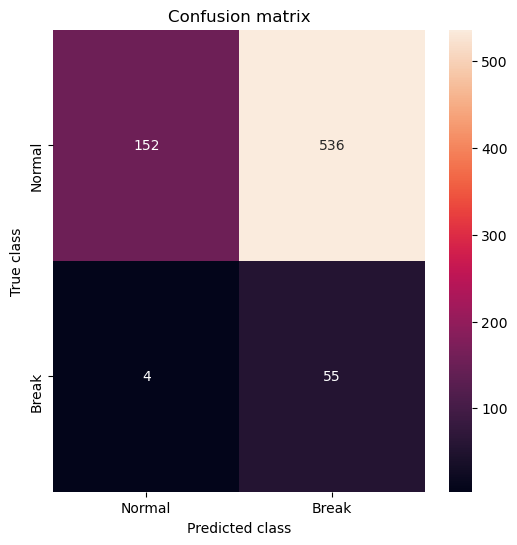

In [59]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [60]:
target_names = ['Normal', 'Break']

print(classification_report(error_df.True_class, pred_y, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.97      0.22      0.36       688
       Break       0.09      0.93      0.17        59

    accuracy                           0.28       747
   macro avg       0.53      0.58      0.26       747
weighted avg       0.90      0.28      0.35       747



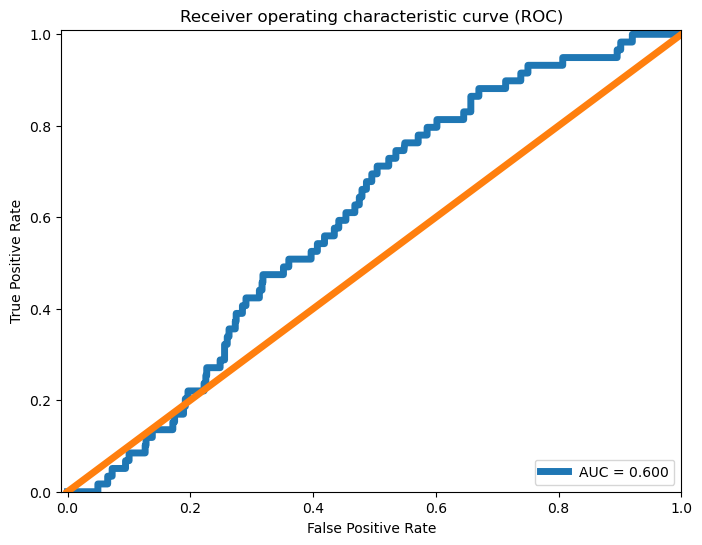

In [61]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()